In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Make all future plots small by default
plt.rcParams['figure.figsize'] = (5, 3)   # width, height in inches
plt.rcParams['axes.titlesize'] = 8        # smaller titles
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

# Load dataset
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
test.drop(['id'], axis=1, inplace=True)

<Axes: >

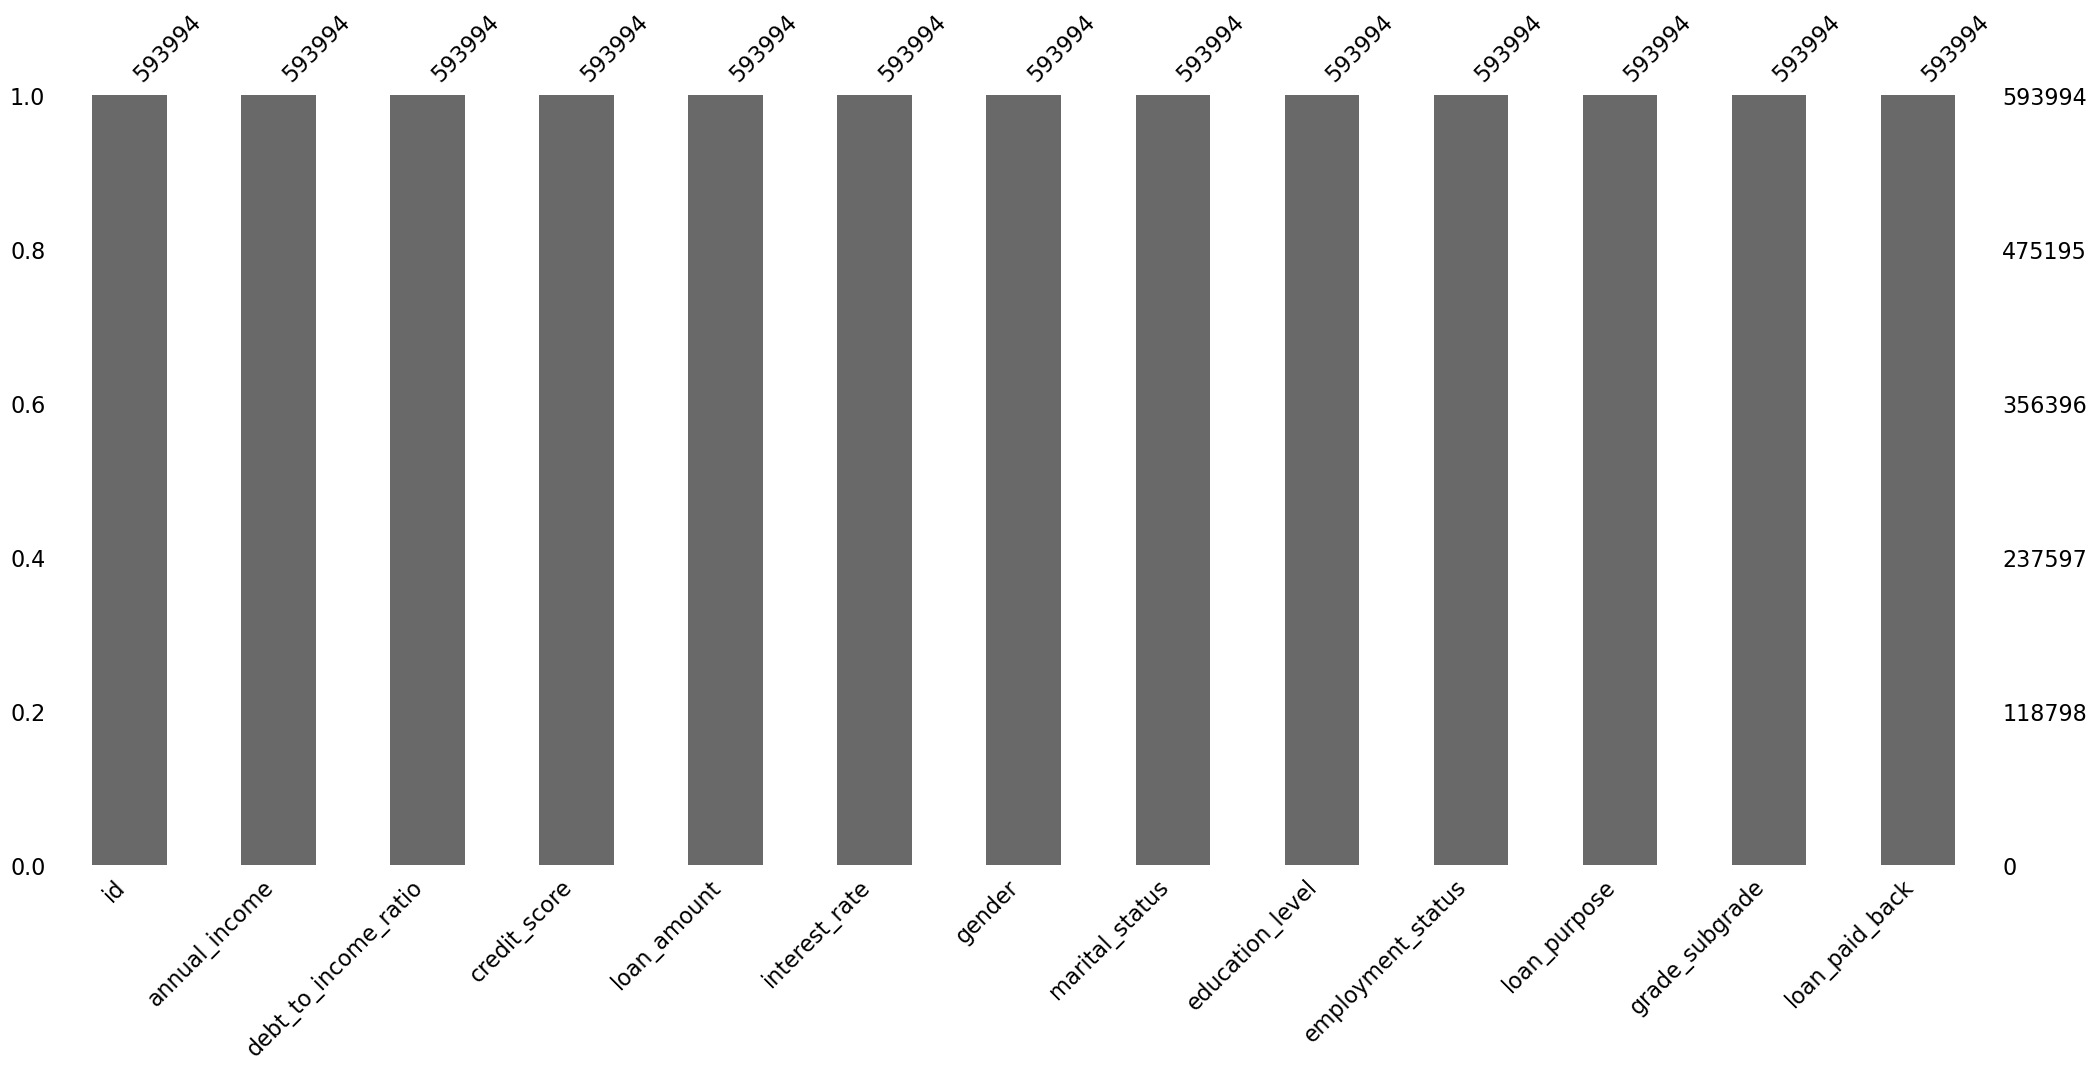

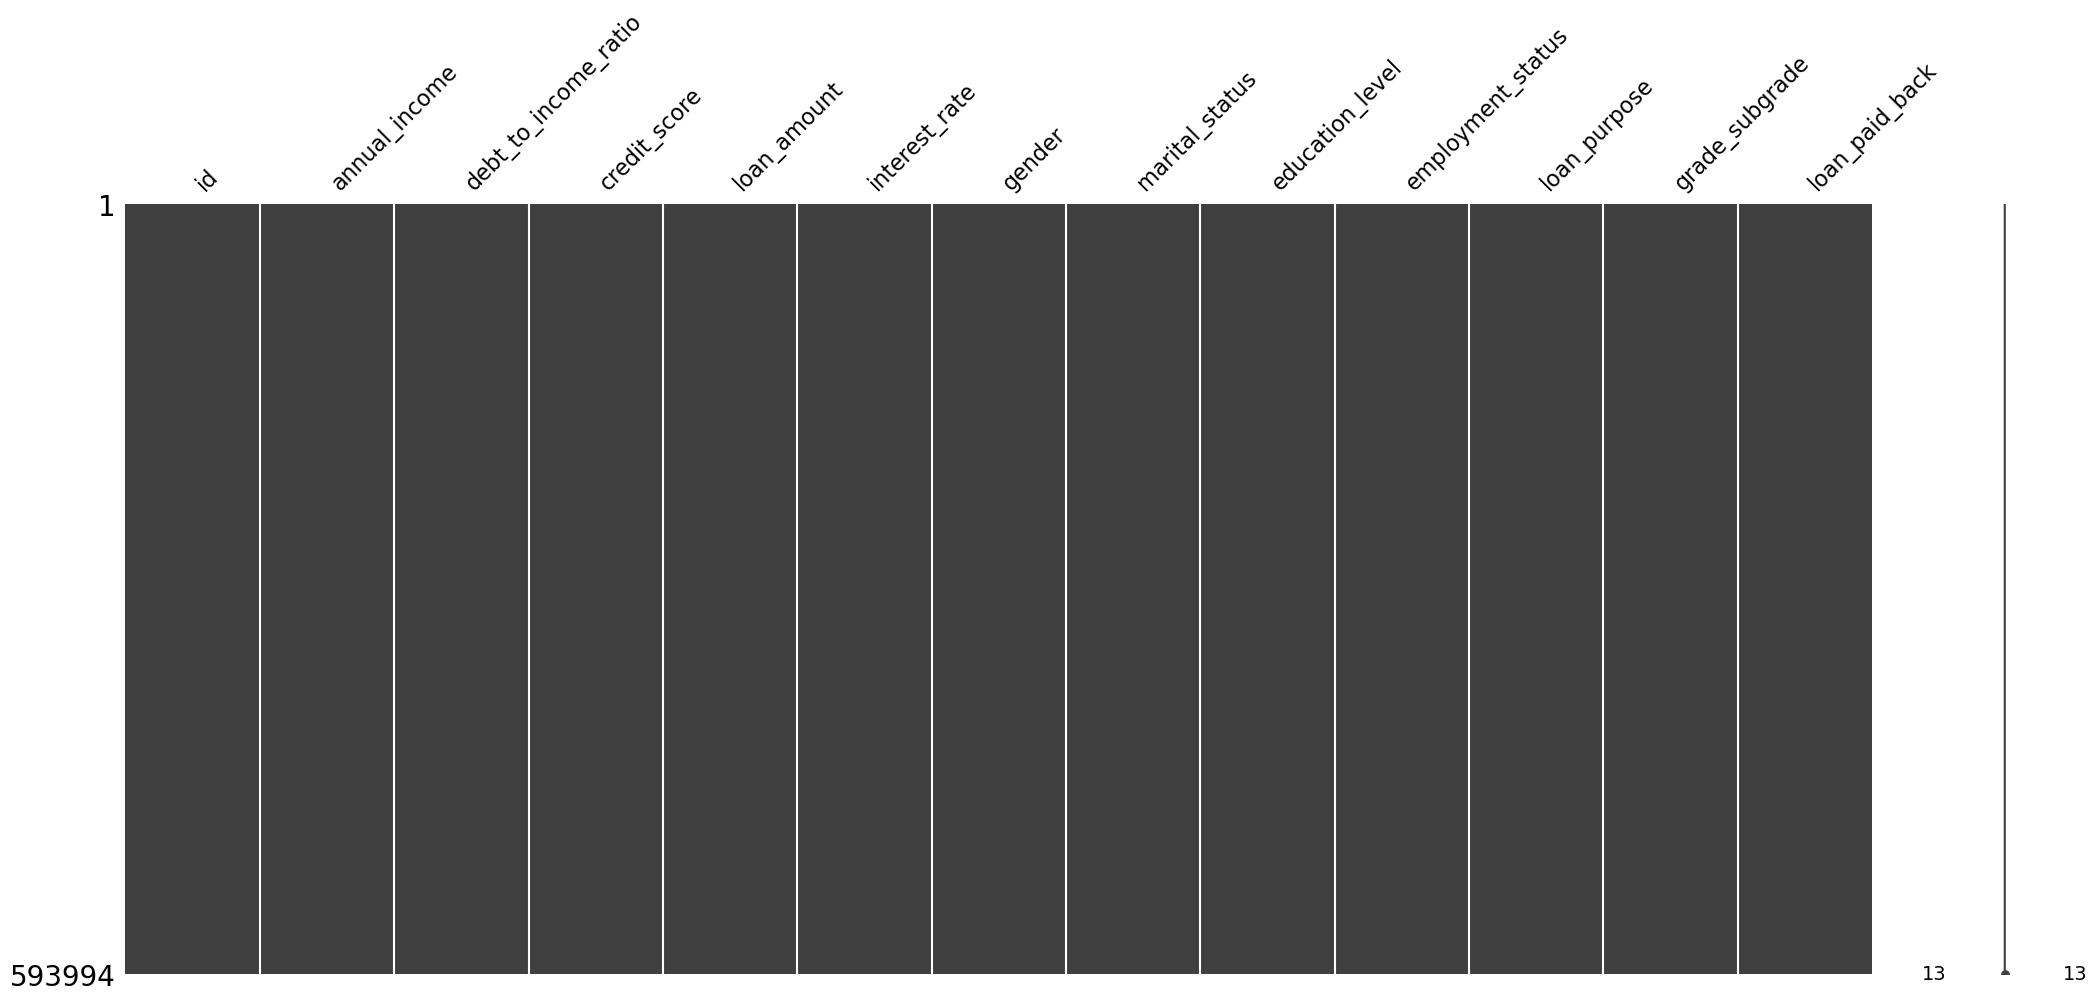

In [3]:
import missingno as msno

# Generate a missingness matrix
msno.bar(df)

msno.matrix(df)





In [4]:
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [5]:
df.drop(['id'], axis=1, inplace=True)

In [13]:
df.loan_paid_back.value_counts()
# Imbalanced dataset.. set class_weight='balanced' in models later

loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 54.4+ MB


In [8]:
df.describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


In [ ]:
X = df.drop('loan_paid_back', axis=1)
y = df['loan_paid_back']

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['number']).columns



# list unique values in categorical columns
for col in cat_cols:
    print(df[col].value_counts())
    print("--------" * 20)


gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64


In [18]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

X = df.drop('loan_paid_back', axis=1)
y = df['loan_paid_back']

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['number']).columns

# train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
# stratify to maintain class distribution in train and val sets, esp for imbalanced datasets!!!
 
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)],
    remainder= 'passthrough')  # to keep any other columns not specified

# classfication models
models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

# fit and evaluate models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 
for name, pipeline in pipelines.items():
    # cross-validation
    cv_scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=['f1', 'roc_auc'], n_jobs=-1)
    print(f"{name} CV F1 Mean Scores: {np.mean(cv_scores['test_f1'])}")
    print(f"{name} CV ROC-AUC Mean: {np.mean(cv_scores['test_roc_auc'])}")
    
    # fit on full training data
    pipeline.fit(X_train, y_train)
    
    # evaluate on validation set
    y_pred = pipeline.predict(X_val)
    print(f"{name} Validation F1 Score: {f1_score(y_val, y_pred)}")
    print(f"{name} ROC-AUC: {roc_auc_score(y_val, pipeline.predict_proba(X_val)[:,1])}")
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    print("--------" * 20)

    # we will set the best model as the one with highest validation F1 score, highest ROC-AUC on validation set


RandomForest CV F1 Mean Scores: 0.9406519131972136
RandomForest CV ROC-AUC Mean: 0.904447105579835
RandomForest Validation F1 Score: 0.9406061585384328
RandomForest ROC-AUC: 0.9043427443076346
              precision    recall  f1-score   support

         0.0       0.89      0.58      0.70     23900
         1.0       0.90      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90      0.78      0.82    118799
weighted avg       0.90      0.90      0.89    118799

[[13901  9999]
 [ 1763 93136]]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
LogisticRegression CV F1 Mean Scores: 0.911161223101606
LogisticRegression CV ROC-AUC Mean: 0.9109363879520466
LogisticRegression Validation F1 Score: 0.9107081839531819
LogisticRegression ROC-AUC: 0.9106886303831235
              precision    recall  f1-score   support

         0.0    

/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost CV F1 Mean Scores: 0.942216138545476
XGBoost CV ROC-AUC Mean: 0.9193500233614555


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:37:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation F1 Score: 0.942294340923027
XGBoost ROC-AUC: 0.9195905508172727
              precision    recall  f1-score   support

         0.0       0.88      0.60      0.72     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.89      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799

[[14441  9459]
 [ 1928 92971]]
----------------------------------------------------------------------------------------------------------------------------------------------------------------


Plotting ROC-AUC curve to compare models:

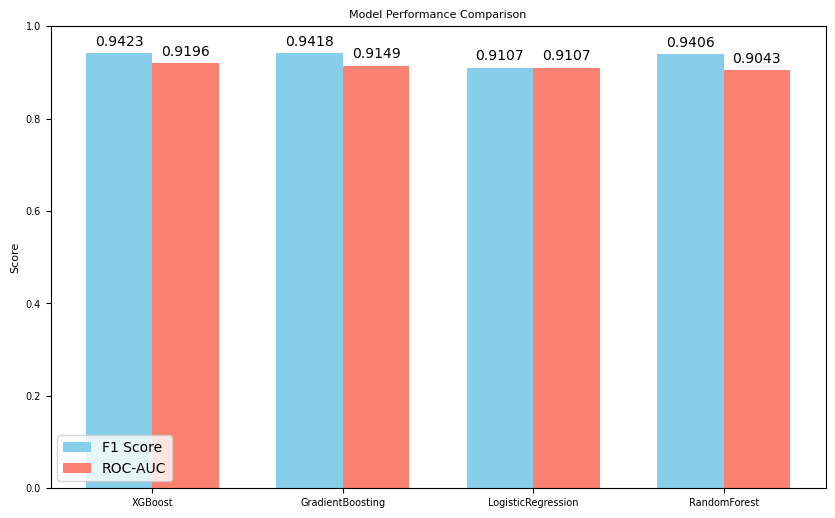

In [29]:
# Plotting F1 Score vs ROC-AUC for each model
models = ['XGBoost', 'GradientBoosting', 'LogisticRegression', 'RandomForest']

# Corresponding metrics
f1_scores = [0.9423, 0.9418, 0.9107, 0.9406]
roc_auc_scores = [0.9196, 0.9149, 0.9107, 0.9043]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score', color='skyblue')
rects2 = ax.bar(x + width/2, roc_auc_scores, width, label='ROC-AUC', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()

# Add value labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()




In [49]:
# Get the trained XGBoost pipeline
xgb_pipeline = pipelines['XGBoost']

# Predict class labels
y_test_pred = xgb_pipeline.predict(test)

# Predict probabilities (for ROC-AUC or other metrics)
y_test_proba = xgb_pipeline.predict_proba(test)[:, 1]  # probability of class 1


# Save predictions to CSV

table = pd.DataFrame({
    'id': range(593994, 593994 + test.shape[0]),  
    'predicted_label': y_test_pred, # 0 or 1
    'loan_paid_back': y_test_proba # probability of paying back loan
 })

submission = table[['id', 'loan_paid_back']] # this returns a DataFrame with only the 'id' and 'predicted_proba' columns
submission.to_csv('xgboost_test_predictions.csv', index=False)


XGBoost has the highest f1-score and ROC-AUC among the three models evaluated.

In [50]:
# Find the best hyperparameters for XGBoost using GridSearchCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_job=-1)

param_dist = {
    'classifier__n_estimators': [100, 300, 500, 700, 850, 1000, 1200],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__min_child_weight': [1, 3, 5, 7],
    'classifier__gamma': [0, 0.1, 0.3, 0.5, 1],
    'classifier__reg_alpha': [0, 0.01, 0.1, 1],
    'classifier__reg_lambda': [1, 1.5, 2, 5]
}
pipelineee = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', best_model)
    ])


random_search = RandomizedSearchCV(
    estimator=pipelineee,
    param_distributions=param_dist,
    n_iter=10,            
    scoring='roc_auc',     
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))



Fitting 3 folds for each of 50 candidates, totalling 150 fits


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:10:21] WARNI

[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=850, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=0.8; total time= 2.2min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=850, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=0.8; total time= 2.3min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:12:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:12:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 2.5min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 2.6min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 2.6min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:12:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:12:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:12:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=700, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 3.0min
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=700, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 3.0min
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=700, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 3.0min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:13:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 1.4min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:14:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 1.4min
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 1.4min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:14:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:14:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=850, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=0.8; total time= 2.5min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:15:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.3, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=500, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.8; total time= 2.2min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:15:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.3, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=500, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.8; total time= 2.0min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:15:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.3, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=500, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.8; total time= 1.9min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:16:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=1, classifier__n_estimators=1200, classifier__reg_alpha=0.01, classifier__reg_lambda=1.5, classifier__subsample=0.9; total time= 2.2min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:16:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=1, classifier__n_estimators=1200, classifier__reg_alpha=0.01, classifier__reg_lambda=1.5, classifier__subsample=0.9; total time= 2.0min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.7; total time=   8.1s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=1000, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 4.3min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=700, classifier__reg_alpha=0.01, classifier__reg_lambda=1, classifier__subsample=0.6; total time= 1.3min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.7; total time=   7.6s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.7; total time=   7.7s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight

/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:18] WARNI

[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=700, classifier__reg_alpha=0.01, classifier__reg_lambda=1, classifier__subsample=0.6; total time= 1.3min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=1000, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 4.2min
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=2, classifier__subsample=0.6; total time=   8.2s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=5

/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:30] WARNI

[CV] END classifier__colsample_bytree=0.8, classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=2, classifier__subsample=0.6; total time=  10.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=2, classifier__subsample=0.6; total time=  10.3s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.8; total time=  26.0s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.8; total time=  25.4s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.8; total time=  26.1s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:17:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=700, classifier__reg_alpha=0.01, classifier__reg_lambda=1, classifier__subsample=0.6; total time= 1.5min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.3, classifier__learning_rate=0.05, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 1.2min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.3, classifier__learning_rate=0.05, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 1.2min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:18:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:18:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.3, classifier__learning_rate=0.05, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.9; total time= 1.2min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:18:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=1, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=1200, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.9; total time= 1.3min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:18:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=1, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=1200, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.9; total time= 1.3min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=1, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=1200, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.9; total time= 1.4min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:19:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:19:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=850, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 1.5min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:19:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=850, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 1.5min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:19:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.3, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=1000, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.8; total time= 1.1min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.3, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=1000, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.8; total time= 1.0min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:19:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.3, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=1000, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.8; total time= 1.1min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=850, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 1.5min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:20:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:20:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=0.1, classifier__reg_lambda=2, classifier__subsample=0.6; total time= 1.5min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=0.1, classifier__reg_lambda=2, classifier__subsample=0.6; total time= 1.5min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:20:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.6; total time= 1.1min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:20:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=0.1, classifier__reg_lambda=2, classifier__subsample=0.6; total time= 1.4min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:20:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:20:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.6; total time= 1.1min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=0.6; total time= 1.2min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:20:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:21:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=1000, classifier__reg_alpha=0.01, classifier__reg_lambda=1, classifier__subsample=0.6; total time= 1.0min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=1000, classifier__reg_alpha=0.01, classifier__reg_lambda=1, classifier__subsample=0.6; total time= 1.0min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:21:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:21:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=1000, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=1.0; total time= 1.8min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=1000, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=1.0; total time= 1.7min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=1000, classifier__reg_alpha=0.01, classifier__reg_lambda=1, classifier__subsample=0.6; total time= 2.1min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:22:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:22:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=1000, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=1.0; total time= 1.7min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:22:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:22:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=100, classifier__reg_alpha=0.01, classifier__reg_lambda=1.5, classifier__subsample=1.0; total time=  22.8s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=850, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 2.1min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:23:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=100, classifier__reg_alpha=0.01, classifier__reg_lambda=1.5, classifier__subsample=1.0; total time=  26.0s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:23:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:23:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=100, classifier__reg_alpha=0.01, classifier__reg_lambda=1.5, classifier__subsample=1.0; total time=  24.5s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:23:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=850, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 1.2min
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=850, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 1.2min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:23:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:23:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=700, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.7; total time=  42.3s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=700, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.7; total time=  40.5s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:24:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:24:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=700, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.8; total time= 1.6min
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=700, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.8; total time= 1.6min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:24:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=700, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.8; total time= 1.4min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:24:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=700, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.7; total time=  35.5s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:25:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.9; total time= 1.4min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:25:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.7; total time= 5.5min
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.7; total time= 5.4min
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.7; total time= 5.4min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:26:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:26:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:26:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.9; total time= 1.4min
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=1000, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.9; total time= 1.4min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.7; total time=  12.4s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.7; total time=  12.2s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__reg_alpha=0.01, classifier__reg_lambda=5, classifier__subsample=0.7; total time=  12.0s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:26:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:26:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.3, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=700, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 1.8min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:26:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.3, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=700, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 1.9min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:27:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=700, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=1.0; total time=  38.8s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:27:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.3, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=700, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time= 2.0min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:27:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=700, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=1.0; total time=  38.6s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:28:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=700, classifier__reg_alpha=0, classifier__reg_lambda=1.5, classifier__subsample=1.0; total time=  33.7s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:28:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=1, classifier__reg_lambda=1.5, classifier__subsample=1.0; total time=  20.1s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:28:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=700, classifier__reg_alpha=0, classifier__reg_lambda=5, classifier__subsample=0.7; total time= 2.6min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=700, classifier__reg_alpha=0, classifier__reg_lambda=5, classifier__subsample=0.7; total time= 2.6min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=700, classifier__reg_alpha=0, classifier__reg_lambda=5, classifier__subsample=0.7; total time= 2.6min
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=3, classifie

/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:28:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:28:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:28:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:28:51] WARNI

[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=1, classifier__reg_lambda=1.5, classifier__subsample=1.0; total time=  24.3s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:29:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time=  20.3s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time=  20.8s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time=  21.3s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:29:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:29:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:29:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=1, classifier__reg_lambda=2, classifier__subsample=0.8; total time=  29.7s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=1200, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=1.0; total time= 3.1min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:29:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:29:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=1200, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=1.0; total time= 3.3min
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=1, classifier__reg_lambda=2, classifier__subsample=0.8; total time=  32.6s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:29:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:29:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=1, classifier__reg_lambda=2, classifier__subsample=0.8; total time=  32.6s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:29:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=1200, classifier__reg_alpha=0.1, classifier__reg_lambda=5, classifier__subsample=1.0; total time= 3.2min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=300, classifier__reg_alpha=0.01, classifier__reg_lambda=2, classifier__subsample=0.6; total time=  23.8s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__reg_alpha=0.01, classifier__reg_lambda=1.5, classifier__subsample=0.7; total time= 1.1min
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__reg_alpha=0.01, classifier__reg_lambda=1.5, classifier__subsample=0.7; total time= 1.1min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:30:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:30:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1.0, classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=300, classifier__reg_alpha=0.01, classifier__reg_lambda=2, classifier__subsample=0.6; total time=  21.7s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:30:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__reg_alpha=0.01, classifier__reg_lambda=1.5, classifier__subsample=0.7; total time= 1.1min
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=300, classifier__reg_alpha=0.01, classifier__reg_lambda=2, classifier__subsample=0.6; total time=  22.7s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:30:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:30:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=1200, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=0.6; total time= 2.3min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:31:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=1200, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=0.6; total time= 2.4min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=1200, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=0.6; total time= 2.3min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:31:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:32:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=0.7; total time=  34.8s
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=0.7; total time=  34.9s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:32:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:32:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time=  16.5s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:32:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=0.7; total time=  27.4s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:33:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time=  20.5s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:33:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=0.6; total time=  20.5s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:33:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=5, classifier__n_estimators=1200, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.9; total time= 3.3min
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.9; total time=  38.6s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=5, classifier__n_estimators=1200, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.9; total time= 3.4min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:33:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:33:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:33:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.9; total time=  38.5s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:34:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.9; total time=  41.7s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:34:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=5, classifier__n_estimators=1200, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.9; total time= 3.1min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:34:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=1200, classifier__reg_alpha=0.1, classifier__reg_lambda=1, classifier__subsample=0.7; total time= 4.8min
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=1200, classifier__reg_alpha=0.1, classifier__reg_lambda=1, classifier__subsample=0.7; total time= 4.8min
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.3, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=1000, classifier__reg_alpha=0.1, classifier__reg_lambda=1.5, classifier__subsample=0.7; total time= 1.3min
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.3, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight

/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=5, classifier__n_estimators=1200, classifier__reg_alpha=0.1, classifier__reg_lambda=1, classifier__subsample=0.7; total time= 4.8min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=0.1, classifier__reg_lambda=1.5, classifier__subsample=0.6; total time=  40.8s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:13] WARNI

[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.3, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=1000, classifier__reg_alpha=0.1, classifier__reg_lambda=1.5, classifier__subsample=0.7; total time= 1.3min
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.7; total time=  16.3s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.7; total time=  15.9s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=100, classifier__reg_alpha=1, classifier__reg_lambda=1, classifier__subsample=0.7; total time=  15.8s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=0.1, classifier__reg_lambda=1.5, classifier__subsample=0.6; total time=  42.2s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.3, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=300, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=1.0; total time=  27.4s
[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.3, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=300, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=1.0; total time=  27.8s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.3, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=300, classifier__reg_alpha=0, classifier__reg_lambda=2, classifier__subsample=1.0; total time=  27.0s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.6, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=500, classifier__reg_alpha=0.1, classifier__reg_lambda=1.5, classifier__subsample=0.6; total time=  45.4s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=850, classifier__reg_alpha=0.1, classifier__reg_lambda=1, classifier__subsample=0.9; total time=  50.9s
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=850, classifier__reg_alpha=0.1, classifier__reg_lambda=1, classifier__subsample=0.9; total time=  50.3s
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=850, classifier__reg_alpha=0.1, classifier__reg_lambda=1, classifier__subsample=0.9; total time=  50.2s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:36:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:36:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:36:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=700, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=1.0; total time=  55.7s
[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=700, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=1.0; total time=  55.5s


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:37:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=500, classifier__reg_alpha=1, classifier__reg_lambda=1.5, classifier__subsample=0.8; total time= 1.6min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:37:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=500, classifier__reg_alpha=1, classifier__reg_lambda=1.5, classifier__subsample=0.8; total time= 1.6min


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:37:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.9, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=1, classifier__n_estimators=700, classifier__reg_alpha=1, classifier__reg_lambda=5, classifier__subsample=1.0; total time=  32.0s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__min_child_weight=7, classifier__n_estimators=500, classifier__reg_alpha=1, classifier__reg_lambda=1.5, classifier__subsample=0.8; total time= 1.5min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=3, classifier__n_estimators=850, classifier__reg_alpha=1, classifier__reg_lambda=2, classifier__subsample=0.6; total time= 2.4min
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0.5, classifier__learning_rate=0.2, classifier__max_depth=7, classifier__min_child_weight=3, clas

/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:38:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_job", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'classifier__subsample': 1.0, 'classifier__reg_lambda': 1.5, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 500, 'classifier__min_child_weight': 3, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.8}
Validation ROC-AUC: 0.9209326145070065


Best parameters: {'classifier__subsample': 1.0, 'classifier__reg_lambda': 1.5, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 500, 'classifier__min_child_weight': 3, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.8}
Validation ROC-AUC: 0.9209326145070065

In [58]:
# Roc-auc was higher after hyperparameter tuning (0.9209 vs 0.9196)
# But it took 28mins to run 10 iterations of RandomizedSearchCV!

# Make predictions (class labels)
y_test_pred = best_model.predict(test)

# Make prediction probabilities (for ROC-AUC or thresholding)
y_test_proba = best_model.predict_proba(test)[:, 1]

# Example: create submission dataframe if you have an ID column
submission2 = pd.DataFrame({
    'id': range(593994, 593994 + test.shape[0]),  
    'loan_paid_back': y_test_proba
})

submission2.to_csv('xgboost_test_predictions_tuned.csv', index=False)


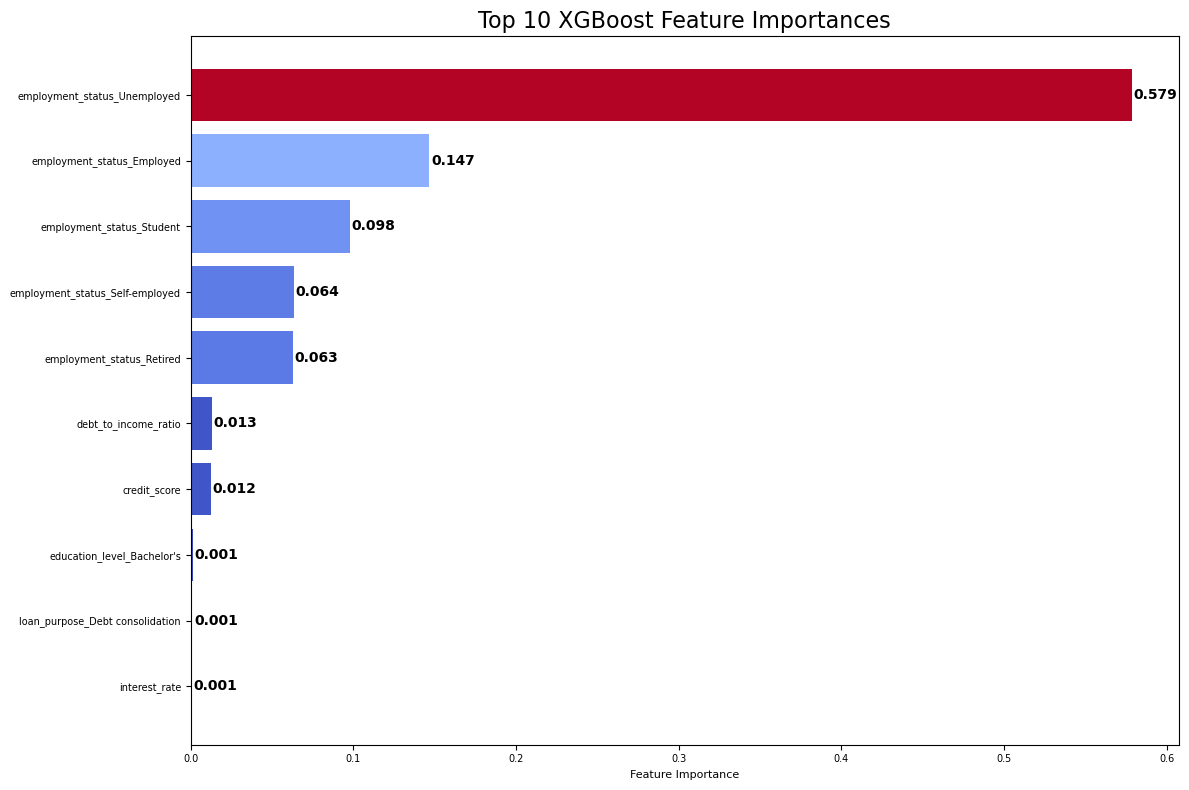

In [62]:
# Visualize most important features from XGBoost
from matplotlib.cm import coolwarm

# Extract trained XGBClassifier
xgb_clf = best_model.named_steps['classifier']

# Get feature names after preprocessing
ohe_features = best_model.named_steps['preprocessor']\
    .named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, ohe_features])

# Get feature importances
importances = xgb_clf.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]

# Top N features
top_n = 10
top_features = feature_names[sorted_idx[:top_n]]
top_importances = importances[sorted_idx[:top_n]]

# Normalize importances for color intensity
colors = coolwarm(top_importances / top_importances.max())

plt.figure(figsize=(12, 8))
bars = plt.barh(range(top_n), top_importances[::-1], color=colors[::-1])
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 XGBoost Feature Importances", fontsize=16)

# Add numbers on bars
for i, v in enumerate(top_importances[::-1]):
    plt.text(v + 0.001, i, f"{v:.3f}", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()
